# Discussion Forum Data
_Last Updated: 27th June by Jing_  
We are currenly using the discussion forum data for DS101X_1T2016 to gain an overview of .mongo data fields and to explore questions that might be interesting. By Monday 27th June, this .ipynb only works with .mongo file alone. We will further integrate other data sources (mainly on user and course) to draw deeper insights. And we also propose questions that might be interesting for further studies.  

_Note:
The following codes uses
**`db = test
collection = fst`** that has already been setup. For more infomation about setting up MongoDB please see MongoDB documentations.  
We will consider adding codes for DB setup._


In [1]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import date
import time
client = MongoClient()
"""
TBS: CODES TO CREATE DB/COLLECTIONS
currently using a establised one : test.large
"""
# By default: localhost 27017
db = client.test
cursor = db.fst.find({})#
mong = []
for document in cursor:
    mong.append(document) #Which gives a list of dictionaries

In [2]:
df = pd.DataFrame.from_dict(mong) #Each dictionary has the same fields so easy to pd
print(df.columns)

Index([u'_id', u'_type', u'abuse_flaggers', u'anonymous',
       u'anonymous_to_peers', u'at_position_list', u'author_id',
       u'author_username', u'body', u'child_count', u'closed',
       u'comment_count', u'comment_thread_id', u'commentable_id', u'context',
       u'course_id', u'created_at', u'depth', u'endorsed', u'endorsement',
       u'historical_abuse_flaggers', u'last_activity_at', u'parent_id',
       u'parent_ids', u'pinned', u'sk', u'thread_type', u'title',
       u'updated_at', u'visible', u'votes'],
      dtype='object')


* We did nothing about the `votes` column (which still saves data as JSON) for we are not using it at the moment. Will probably deal with it later.   

## Data Must-Knows
The followings are fields that needs to be addressed, for either they are important or the names are not self-explanatory enough.  

#### Comments&CommentThreads Shared  
**`_id`** : Unique ID for this collection; Monotonically increasing; first four bytes are a timestamp  
**`_type`**:Comment/Comment_Thread  
**`author_id`**:User ID as in `auth_user.sql`  
**`votes`**:  
_up = list of User IDs that up-voted this comment or thread.  
down = (no longer used) list of User IDs that down-voted this comment or thread.  
up_count = total upvotes received.  
down_count = No longer used. Total downvotes received.  
count = total votes cast.  
point = net vote, now always equal to up_count._  

#### CommentThreads
**`comment_count`** :All comments&Replies excluding the thread itself  
**`commentable_id`**: A component, e.g.“d9f970a42067413cbb633f81cfb12604”; or a top-level, in format`i4x-{org}-{course}-{run}-{name}`  
**`last_activity_at`**: UTC timestamp  
**`thread_type`**: "question" or "discussion"  
**`pinned`**: If a CommentThread is pinned on the top (mostly administrator posts)  
#### Comment 
**`comment_thread_id`**: comment_thread_id it is responding to  
**`abuse_flaggers`**,**`historical_abuse_flaggers`**:IDs of thoes who report "misuse"  
**`parent_id`**: Replying to a comment (depth 1)  
**`parent_ids`**: all parent ids (any depth)  
**`sk`**: A randomly generated number that drives a sorted index to improve online
performance.  
#### No longer used:
`at_position_list`
**???**
`context`;`depth`

## Questions Interested in
We come up with new ideas as we go. But here are the questions we have at the moment.
* How many users posted comments? [USER & Comments]
    - Age, district, education background, language they use, certificates. Who are thoes people who ask questions?  
    - Grades, active forum users get higher grades?
    - Note: have to exclude course staff comments

* How many Comments/CommentThreads[Comments]
    - How many CommentThreads are there   
    - Of all CommentThreads how many of thoes are questions/comments? Do questions get more attention
    
* When do students post questions [Comments & USER & Course]
    - Time series features? General trend and patterns?
    - Whether students tend to post more near deadlines
    - Whether course administrator/tutors' posts encourage more replies from students

* User communications: do people build connections through forum? Are they "similar" in some way or another? [USER & USER]

* _Not sure:_ Text Mining Question: what kind of posts get more replies?

## How Many Active Users

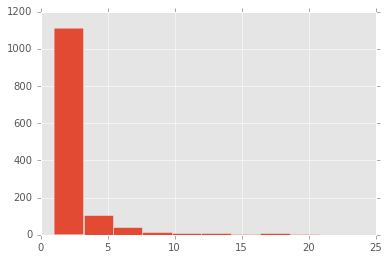

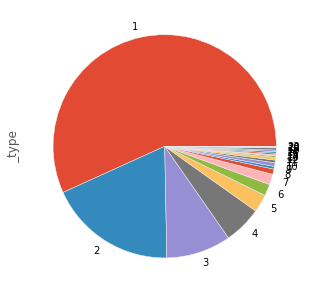

In [3]:
grouped=df.groupby('author_id')
a = grouped.agg('count')
g = a.groupby('_id').agg('count')['_type']
# Histogram
%matplotlib inline
matplotlib.style.use('ggplot')
grouped=df.groupby('author_id')
a = grouped.agg('count').sort_values('_id')['_id']
plt.hist(a)
plt.show()
# Pie-Chart
g.plot.pie(figsize=(5, 5))

## Comments vs. Comment Threads

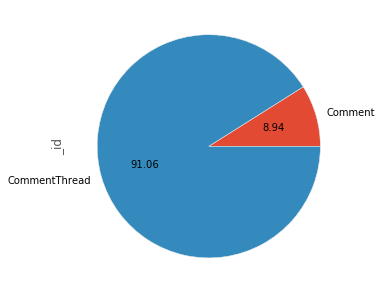

In [4]:
"""How Many Threads&Comments"""
comment_type=df.groupby('_type')
comment_type = comment_type.agg('count').sort_values('_id')['_id']
comment_type.plot.pie(figsize=(5, 5),autopct='%.2f')

Suprising in someways, there are over 8 times more comment threads than comments. Many threads never get replied to. 

#### How many comment threads are questions?

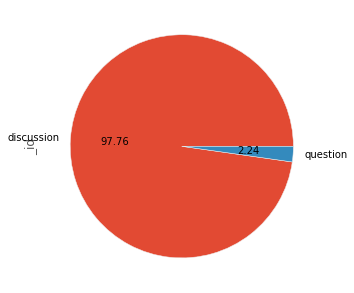

In [5]:
ct=df[df['_type']=='CommentThread']
group_ct=ct.groupby('thread_type').agg('count')['_id']
group_ct.plot.pie(figsize=(5, 5),autopct='%.2f')

Interestingly, most of the threads are "discussion" threads instead of "question" posts.
#### How many responses to each type

Responding to Threas: Question vs. Discussion
thread_type  comment_count
discussion   0.0              2504
             1.0               131
             2.0                15
             3.0                 2
             4.0                 1
             8.0                 2
             10.0                1
             12.0                1
question     0.0                38
             1.0                12
             2.0                 6
             3.0                 3
             12.0                1
             13.0                1
Name: _id, dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117b1d5d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117b938d0>], dtype=object)

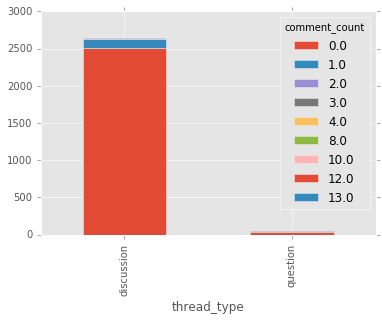

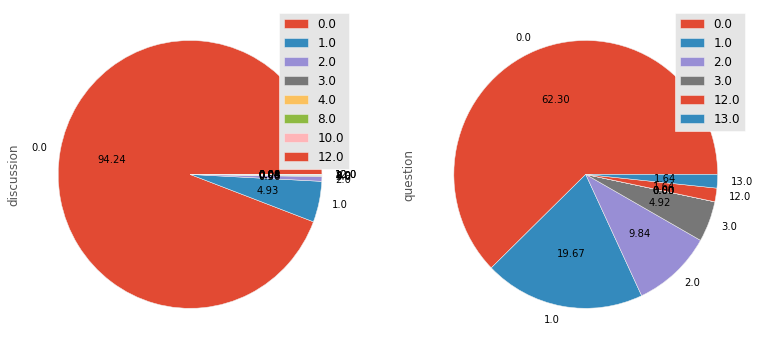

In [6]:
group_ct2=ct.groupby([ct['thread_type'],ct['comment_count']]).agg('count')['_id']
print("Responding to Threas: Question vs. Discussion")
print(group_ct2)
group_ct2.unstack('comment_count').plot.bar(stacked=True)
group_ct2.unstack('thread_type').plot.pie(subplots=True,figsize=(13, 6),autopct='%.2f')

**What questions/discussions got more response? Might be an NLP problem**

In [7]:
print(df.columns)

Index([u'_id', u'_type', u'abuse_flaggers', u'anonymous',
       u'anonymous_to_peers', u'at_position_list', u'author_id',
       u'author_username', u'body', u'child_count', u'closed',
       u'comment_count', u'comment_thread_id', u'commentable_id', u'context',
       u'course_id', u'created_at', u'depth', u'endorsed', u'endorsement',
       u'historical_abuse_flaggers', u'last_activity_at', u'parent_id',
       u'parent_ids', u'pinned', u'sk', u'thread_type', u'title',
       u'updated_at', u'visible', u'votes'],
      dtype='object')


## When do People Post Questions

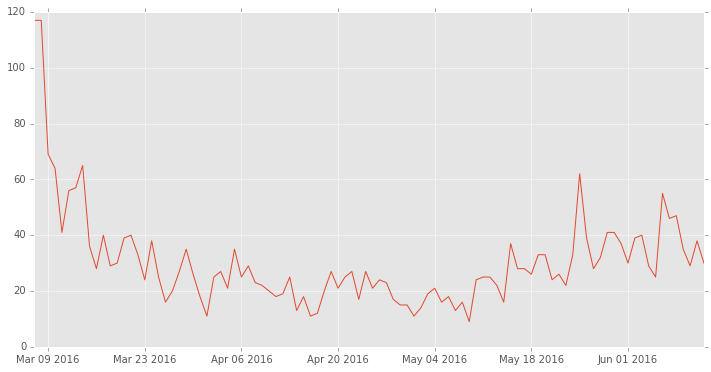

In [8]:
"""NOTE: Need to further understand PYTHON SERIES,GROUPBY to know why sth works """
datedis = df.groupby(df["created_at"].dt.date).agg('count')["_id"] 
%matplotlib inline
plt.figure(figsize=(12,6)) # Set graph size
plt.plot(datedis)
plt.show()

General trend:  
- Most posts in the very beginning  
- Goes down and slightly up at the end (Probably because of final deadline )  
- Up and downs in between, could relate somewhat to:  
    - Staff activity  
    - Minor deadlines  


**Further: what questions to ask and what data to integrate with**  
Mark deadline [_with what?_]  
Mark staff [_with userdata_]  
Hist by week [_time series_]  
Staff vs. None Staff [_with userdata_]  
Audit vs. Certificate[_with userdata_]  
Time Zone (Not currently for it may be interesting by not directly relavant)  

In [9]:
# ##Transferring time stamp to date time
# ts.min().to_datetime()
# print(type(ts.min().to_datetime()))
# print(ts.min().date())

# ts_group=df.groupby(df['created_at'].date())

# ts.min()

# datetime(ts.min())
# index = pd.date_range('2000-1-1', periods=1000, freq='M')

# import math
# Trying to see the Pinned
# aa=0
# i=0
# ind=[]
# for pin in df['pinned']:
#     tf = math.isnan(pin)
#     if tf == 0:
#         ind.append(i)
#     aa+=1-math.isnan(x)
#     i+=1
# df.iloc[ind]

#type(df['updated_at'][1])